E_GS =  [-2.6]
gap =  1.5999999999999994
|<psi0|psiGS>| =  5.551115123125783e-17
n= 0


/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_73928/2557965678.py:77: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Nt_kraus = np.int(T_kraus/(2*np.pi/(4*a)))
/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_73928/2557965678.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

n= 1
n= 2
n= 3
n= 4
n= 5


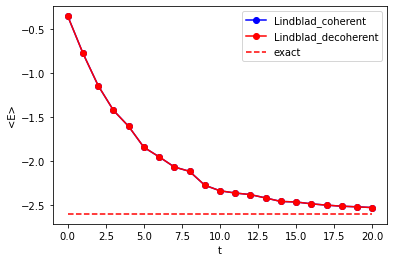

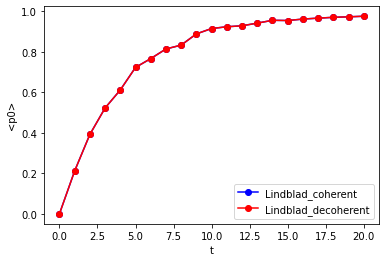

In [1]:
# %load tfim1d.py
"""
Test Lindblad based method for ground state preparation for TFIM.

Lin Lin
Last revision: 04/18/2023
"""

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as la
from qutip import Qobj, mesolve

from lindblad import Lindblad


if __name__ == "__main__":
    ##### define model parameters #####
    L=2 # system size
    J=1.0 # spin zz interaction
    g=1.2 # z magnetic field strength
    	
    ##### define spin model
    # site-coupling lists (PBC for both spin inversion sectors)
    h_field=[[-g,i] for i in range(L)]
    J_zz=[[-J,i,i+1] for i in range(L-1)] # no PBC
    # define spin static and dynamic lists
    static =[["zz",J_zz],["x",h_field]] # static part of H
    dynamic=[] # time-dependent part of H
    # construct spin basis in pos/neg spin inversion sector depending on APBC/PBC
    spin_basis = spin_basis_1d(L=L)
    # build spin Hamiltonians
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H=hamiltonian(static,dynamic,basis=spin_basis,dtype=np.float64,**no_checks)
    # calculate spin energy levels
    E_GS,psi_GS = H.eigsh(k=1,which="SA")
    psi_GS = psi_GS.flatten()
    print('E_GS = ', E_GS)
    
    H_mat = np.array(H.todense())
    E_H , psi_H = la.eigh(H_mat)
    gap = E_H[1] - E_H[0]
    print('gap = ', gap)

    a = 2*la.norm(H_mat,2)
    da = 2*la.norm(H_mat,2)
    b = 0.3 * gap
    db = 0.3 * gap
    
    filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 

    A = hamiltonian([ ['z',[[1.0,0]]] ],[],basis=spin_basis,dtype=np.float64,**no_checks)
    A_mat = np.array(A.todense())

    lb = Lindblad(H_mat, A_mat, filter_params)

    # fix the random seed
    np.random.seed(seed=1)
    vt = np.random.randn(lb.Ns)
    # worst case in some sense: make psi0 and psi_GS orthogonal
    psi0 = vt.copy()
    psi0 -= psi_GS * np.vdot(psi_GS,psi0)
    psi0 = psi0 / la.norm(psi0)
    print('|<psi0|psiGS>| = ', np.abs(np.vdot(psi_GS,psi0)))
    T = 20
    K=6
    num_seg_1=np.zeros(K)
    rho_error=np.zeros(K)
    for n in range(K):
        print('n=',n)
        num_t=T
        T_kraus = 5 / db
        Nt_kraus = np.int(T_kraus/(2*np.pi/(4*a)))
        num_segment = np.int(2**n)
        num_rep = 100
        num_seg_1[n] = np.int(2**n)
        times = np.arange(num_t+1) * (T/num_t)

        mode = 'coherent'
        lb.construct_kraus_coherent_time(T_kraus, Nt_kraus)
        times, avg_H_c, avg_pGS_c, rho_all_c = lb.evolve_kraus_coherent(T, num_t, psi0,
                num_rep, psi_GS)
        mode = 'decoherent'
        times, avg_H_de, avg_pGS_de, num_gate, rho_all_de = lb.evolve_kraus_decoherent_batch(T, num_t,
                num_segment, psi0, num_rep, T_kraus, Nt_kraus,
                psi_GS, intorder=2)
        for it in range(np.int(num_t)):
            rho_error[n]=rho_error[n]+la.norm(lb.eHT@rho_all_de[:,:,it]@lb.eHT.conj().T-rho_all_c[:,:,it], 'nuc')
        rho_error[n]=rho_error[n]/np.int(num_t)
        #plot
        if n==K-1:
            plt.plot(times, avg_H_c, 'b-o', label='Lindblad_coherent')
            plt.plot(times, avg_H_de, 'r-o', label='Lindblad_decoherent')
            plt.plot(times, np.ones_like(times)*E_GS, 'r--', label='exact')
            plt.legend()
            plt.xlabel('t')
            plt.ylabel('<E>')
            plt.show()

            plt.plot(times, avg_pGS_c, 'b-o', label='Lindblad_coherent')
            plt.plot(times, avg_pGS_de, 'r-o', label='Lindblad_decoherent')
            plt.legend()
            plt.xlabel('t')
            plt.ylabel('<p0>')
            plt.show()

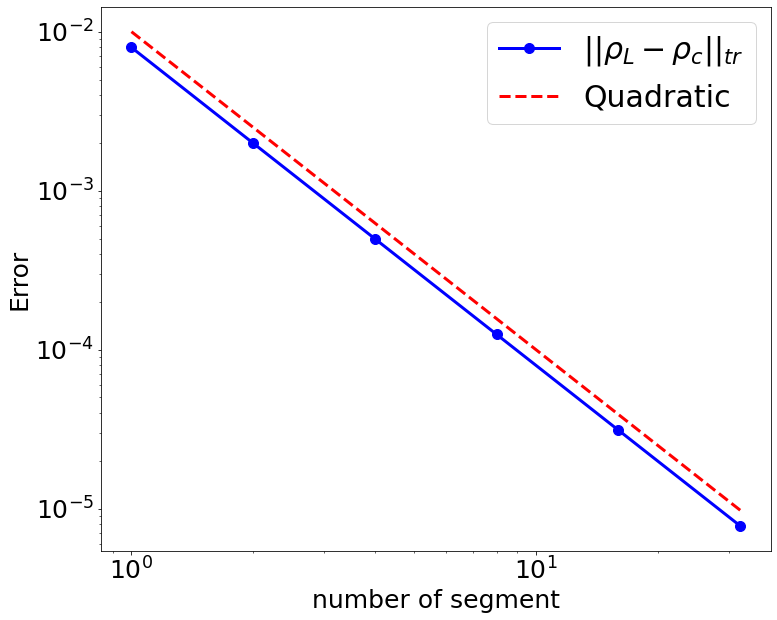

In [2]:
# Error checking (decoherent vs coherent)
plt.figure(figsize=(12,10))
plt.plot(num_seg_1, np.abs(rho_error), 'b-o', label=r'$||\rho_L-\rho_c||_{tr}$', linewidth=3,markersize=10)
plt.plot(num_seg_1, 0.01/num_seg_1**2, 'r--', label='Quadratic', linewidth=3,markersize=10)
plt.legend()
plt.xlabel('number of segment',fontsize=25)
plt.ylabel('Error',fontsize=25)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('Error_coherent_vs_decoherent.pdf')
plt.show()